In [1]:
import pandas as pd
# import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
tesla = pd.read_csv('tsla.us.txt',index_col=0)
tesla = tesla[['Close']]

In [3]:
tesla.isnull().sum()

Close    0
dtype: int64

<AxesSubplot:xlabel='Date'>

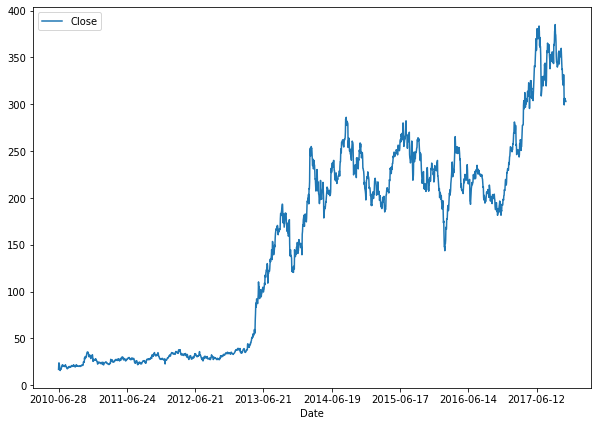

In [4]:
tesla.plot(figsize=(10,7))

<AxesSubplot:xlabel='Date'>

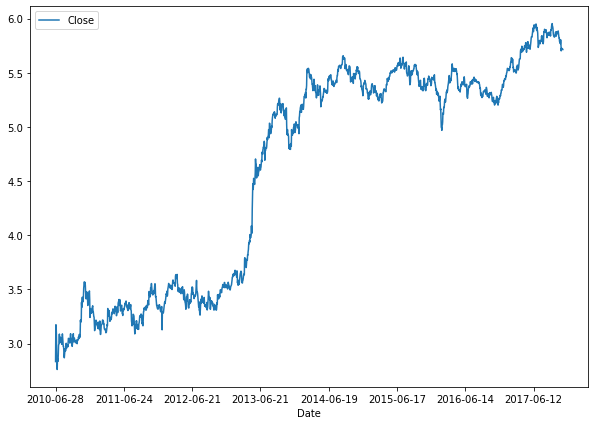

In [5]:
#log transformed
tesla = np.log(tesla)
tesla.plot(figsize=(10,7))

Selecting for (p,d,q) parameters.

<AxesSubplot:xlabel='Date'>

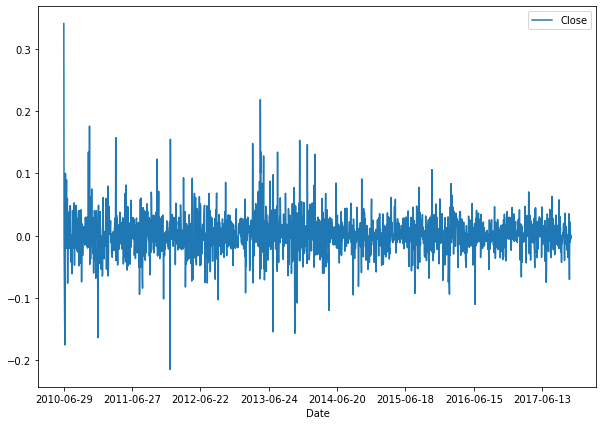

In [6]:
tesla_diff = tesla.diff()
tesla_diff.drop(tesla.index[0],inplace=True)
tesla_diff.plot(figsize=(10,7))

In [7]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(tesla.values)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.345080590931957
p-value: 0.6083040184285746


The ADF test where p-value is > .05, failed and indicated the data is non-stationary.

In [8]:
# Augmented Dickey-Fuller test by differencing order of 1
ad_fuller_result = adfuller(tesla_diff.values)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -43.44273737289829
p-value: 0.0


The ADF test where p-value is < .05, passed and indicated the data when differenced, is stationary.

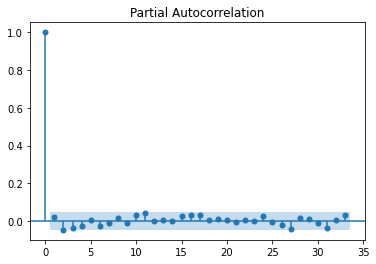

In [9]:
plot_pacf(tesla_diff);

For P, using the PACF chart, we can select 2, 3, or 11 as these are the values on or exceed the lines of significance

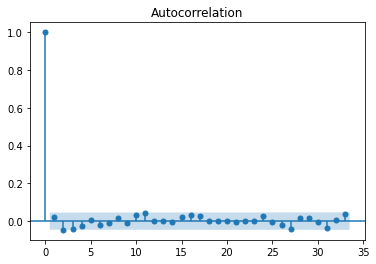

In [10]:
plot_acf(tesla_diff);

For Q, using the ACF, 2,3, or 11.

## ARIMA model

In [11]:
#Declaring train and test values
X = tesla.values
train_X_size = int(round(len(X)*.8))
test_X_size = int(round(len(X)*.2))
train_X, test_X = X[0:int(len(X)*.8)], X[int(len(X)*.8):] 

AIC -5725.024711523705
RMSE 0.023415011717412414


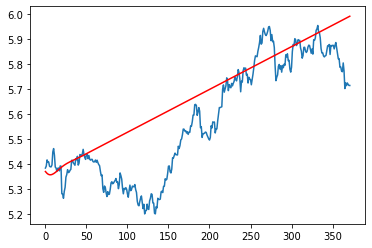

In [12]:
model_arima = ARIMA(train_X,order=(3,1,3))
model_arima_fit = model_arima.fit()
predictions = model_arima_fit.forecast(steps=test_X_size)[0]

print('AIC', model_arima_fit.aic)
print('RMSE',mean_squared_error(test_X,predictions))
plt.plot(test_X)
plt.plot(predictions, color='red')

In [13]:
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1485
Model:                 ARIMA(3, 1, 3)   Log Likelihood                2870.512
Method:                       css-mle   S.D. of innovations              0.035
Date:                Sat, 13 Mar 2021   AIC                          -5725.025
Time:                        11:30:41   BIC                          -5682.599
Sample:                             1   HQIC                         -5709.212
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      1.759      0.079      -0.000       0.004
ar.L1.D.y      1.6724      0.494      3.386      0.001       0.704       2.640
ar.L2.D.y     -0.6092      0.937     -0.650      0.5

p and q are both significant at 3. We will rerun the model with parameters (1,1,1)

AIC -5720.461842038299
RMSE 0.028384948017577107


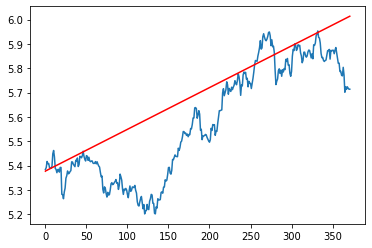

In [14]:
model_arima = ARIMA(train_X,order=(1,1,1))
model_arima_fit = model_arima.fit()
predictions = model_arima_fit.forecast(steps=test_X_size)[0]

print('AIC', model_arima_fit.aic)
print('RMSE',mean_squared_error(test_X,predictions))
plt.plot(test_X)
plt.plot(predictions, color='red')

Slightly better AIC but worse RMSE.

(array([  3.,   6.,  74., 815., 541.,  32.,  11.,   2.,   0.,   1.]),
 array([-0.21610645, -0.16064272, -0.10517899, -0.04971526,  0.00574847,
         0.0612122 ,  0.11667593,  0.17213966,  0.2276034 ,  0.28306713,
         0.33853086]),
 <BarContainer object of 10 artists>)

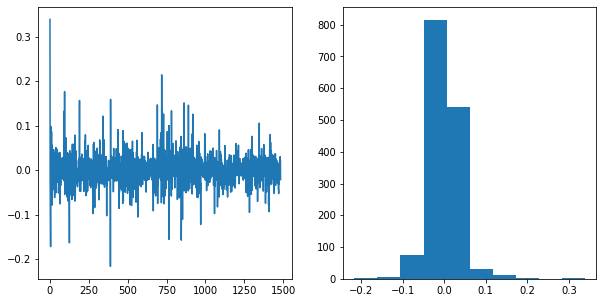

In [15]:
residuals = pd.DataFrame(model_arima_fit.resid)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(residuals)
ax2.hist(residuals)

A display of normal errors in training data.

### Bonus

In [16]:
tesla.tail(1)

,Close
Date,
2017-11-10,5.7137


The last set of data ends on 11/10/2017. Now lets fit all test data with our predicted values. As a bonus, lets see where the ln(price) would be after one year (253 trading days). The 11/12/2018 adj price of Tesla is 66.26 and pre adjusted is 331.30. 

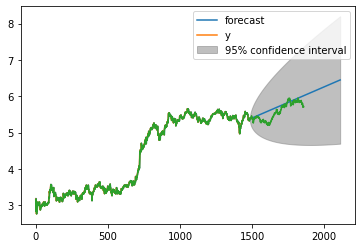

In [17]:
model_arima_fit.plot_predict(1,X.size+253,dynamic=False);
plt.plot(X)

In [18]:
print('ln(price) of Tesla after one year, 11/12/2018 is {}, which is within the 95% confidence predicted.'.format(np.log(66.26*5).round(2)))

ln(price) of Tesla after one year, 11/12/2018 is 5.8, which is within the 95% confidence predicted.
